In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


ده تصویر را از یک وبسایت با تصاویر رایگان دانلود کنید (مثالا pixabay.com). با استفاده از شبکه YOLO تمام objectهای درون این تصاویر را detect کنید. تصاویر اصلی و تصاویر بعد از object detection را نمایش دهید.



* قسمت کد پاسخ خود را به صورت لینک Colab یا فایل نوت‌بوک با پسوند .ipynb بفرستید. برای تسریع فرایند تصحیح کد خود را کامنت‌گذاری کنید.

* حتما قبل از ارسال کد را اجرا کنید تا نتایج در فایل ارسالی وجود داشته باشد.

* قسمت تشریحی پاسخ خود را در یک فایل با فرمت ورد یا پی‌دی‌اف ارسال کنید.

In [3]:
%cd /content/drive/MyDrive/آموزش یادگیری عمیق مکتب خونه

/content/drive/MyDrive/آموزش یادگیری عمیق مکتب خونه


--2024-09-24 11:46:45--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  27.7MB/s    in 7.8s    

2024-09-24 11:46:53 (30.4 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-09-24 11:46:53--  https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pjreddie/darknet/raw/refs/heads/master/cfg/yolov3.cfg [following]
--2024-09-24 11:46:53--  https://github.com/pjreddie/darknet/raw/refs/heads/master/cfg/yolov3.cfg
Reusing existing connection to github.com:443.
HTT

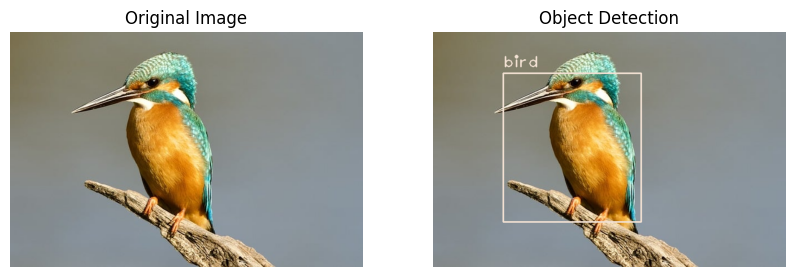

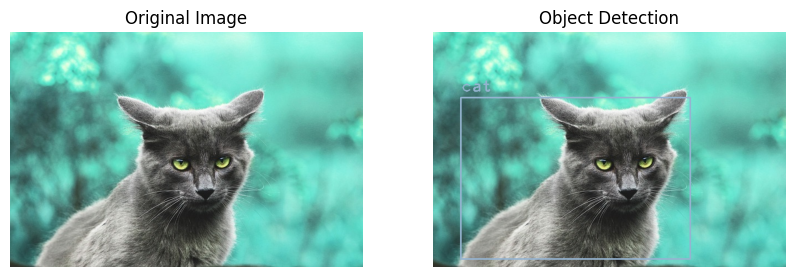

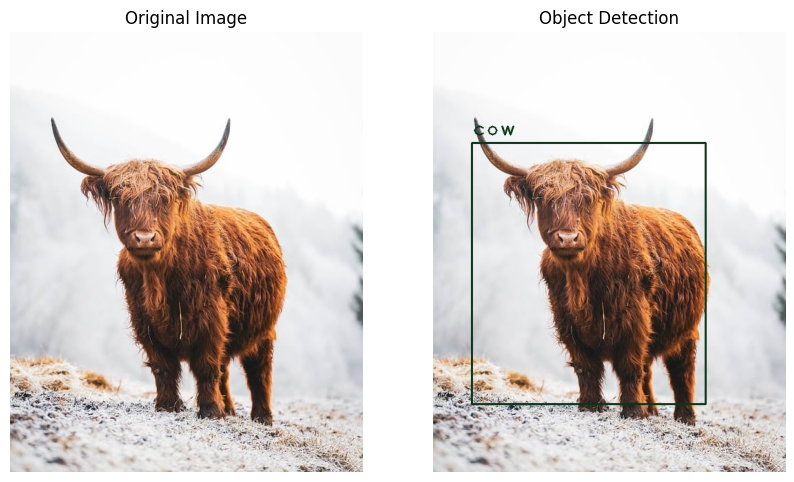

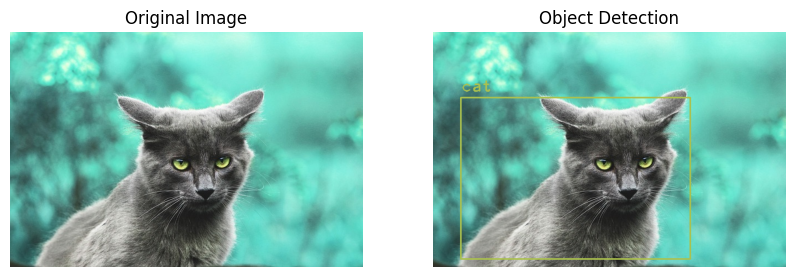

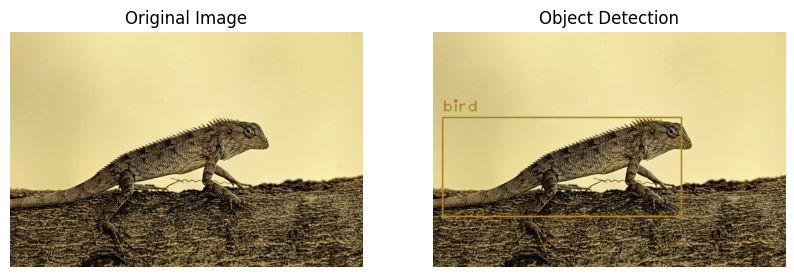

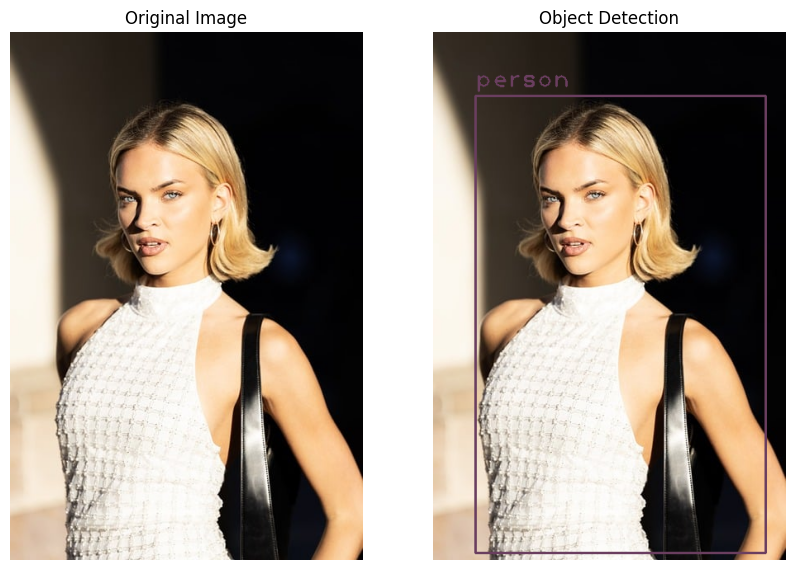

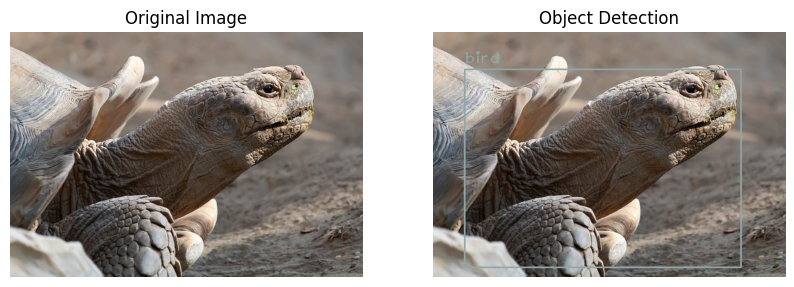

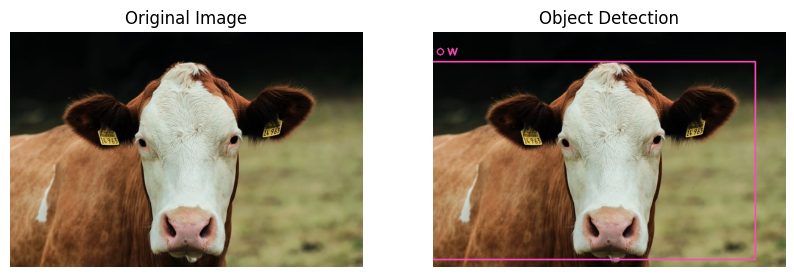

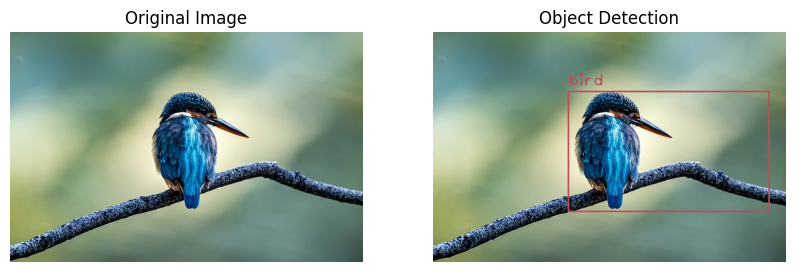

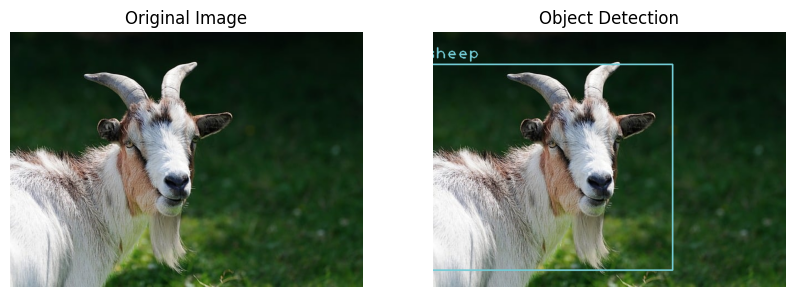

In [9]:
# نصب کتابخانه‌های مورد نیاز
!pip install opencv-python-headless matplotlib

# دانلود فایل‌های مدل YOLOv3
!wget -O yolov3.weights https://pjreddie.com/media/files/yolov3.weights
!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O yolov3.cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names -O coco.names

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# بارگذاری مدل YOLOv3
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# بارگذاری کلاس‌های COCO
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# مسیر پوشه‌ای که تصاویر شما در Google Drive قرار دارند
image_folder = '/content/drive/MyDrive/آموزش یادگیری عمیق مکتب خونه'

# گرفتن لیست تمام فایل‌ها در پوشه
image_files = os.listdir(image_folder)

# فقط تصاویر با فرمت‌های معتبر را انتخاب کنید
valid_image_extensions = [".jpg", ".jpeg", ".png"]  # لیستی از پسوندهای معتبر تصاویر
image_files = [f for f in os.listdir(image_folder) if os.path.splitext(f)[1].lower() in valid_image_extensions]

# فقط ۱۰ تصویر اول را انتخاب کنید
image_files = image_files[:10]

# پردازش هر تصویر و انجام object detection
for img_file in image_files:
    # بارگذاری تصویر از Google Drive
    img_path = os.path.join(image_folder, img_file)
    img = cv2.imread(img_path)

    if img is None:
        print(f"Could not read image {img_file}. Skipping...")
        continue

    height, width, channels = img.shape

    # آماده‌سازی تصویر برای ورودی YOLO
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    # اجرای مدل YOLO
    outputs = net.forward(output_layers)

    # نمایش اشیاء شناسایی شده
    boxes = []
    confidences = []
    class_ids = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # اعمال Non-Maximum Suppression
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    font = cv2.FONT_HERSHEY_PLAIN
    colors = np.random.uniform(0, 255, size=(len(boxes), 3))

    # رسم جعبه‌های کشف شده روی تصویر
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[i]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y - 10), font, 2, color, 2)

    # تبدیل به فرمت RGB برای نمایش در Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # نمایش تصویر اصلی و تصویر پردازش شده در کنار هم
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_rgb)
    plt.title("Object Detection")
    plt.axis('off')

    plt.show()


توضیحات:

1.   مدل YOLOv3: این کد فایل‌های مدل yolov3.weights، yolov3.cfg و coco.names را دانلود می‌کند.
2.   غیر حذفی‌سازی جعبه‌ها (Non-Maximum Suppression): برای جلوگیری از نمایش جعبه‌های تکراری، از NMS استفاده شده است.



